In [1]:
"""
Autohr: Sergi Mas Pujol
Last update: 14/06/2021

Python version: 3.6
"""

'\nAutohr: Sergi Mas Pujol\nLast update: 14/06/2021\n\nPython version: 3.6\n'

In [2]:
import numpy as np
np.random.seed(4)
import sys
import math
import random
random.seed(7)
from random import sample
from datetime import datetime, timedelta, date

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 7]

from utils_samplesTraining import read_REGULATIONS_file
from utils_timeProcessing import from_YYYYMMDDHHMMSS_to_HHMMSS_withTwoDots, \
                                 substract_minutes_given_HHSSMM, add_minutes_given_HHSSMM, \
                                 from_YYYYMMDD_to_DDMMYYYY_given_separator, \
                                 listDays_betweenTwoDates, \
                                 from_YYYYMMDDHHMMSS_to_HHMMSS, \
                                 from_HHMMSS_to_HH                                 
from utils_samplesTraining import readAssociatedFile_fromAIRAC_givenDate, \
                                  extract_regulations,\
                                  addIntervals_toFinalConjunt, \
                                  compute_start_end_timestamps_from_days_with_regulations
from generator import extract_features_from_list_days_and_timestamps, \
                      extract_days_timestamps_volumes_labels_days_with_regulations

from generator_weather import extract_weather_information_from_list_days_and_timestamps

In [3]:
from keras.models import Model
from keras.layers import Dense, Input, Dropout, LSTM, Activation, TimeDistributed
# from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.initializers import glorot_uniform

In [4]:
# Given the start timestamp of the regulation -> Considered time before and after
# Temporal gaps in minutes
gap_before_start_time = 0
gap_after_start_time = 30

In [5]:
num_epochs = 300
batch_size = 32

In [6]:
num_weather_features = 16
num_metric_per_weather_feature = 3

# Prepare / Extreact data

###  Extract the available regulations

In [7]:
REGULATIONS = read_REGULATIONS_file('./20190604_20191020_REGULATIONS.csv')

"""
If the regulation contains a cancel_time -> It will be ignored
    * To take them into account -> Remove last condition
"""
REGULATIONS = REGULATIONS.loc[(REGULATIONS["regulation_reason"].isin([' W-Weather '])) & 
                              (REGULATIONS["location_type"] == ' En route ') &
                              (REGULATIONS["cancel_time"] == '  ')
                             ] 

In [8]:
# TODO: Try to optimaze the following step (very slow)

# Drop all the regulations which are not associated to a "traffic_volume" == "MAS..."
count_drops = 0
for index, row in REGULATIONS.iterrows():
    
    # The .strip() is requieres because there is a white space at the beginning of the names
    if row["traffic_volume"].strip()[0:3] != 'MAS': 
        REGULATIONS = REGULATIONS.drop(index=index)
        count_drops += 1

In [9]:
print('Number ALL regulations from the given sector: ', str(len(REGULATIONS.values)))

Number ALL regulations from the given sector:  151


In [10]:
# ".strip() -> Remove all the white spaaces in the timestamp"

REGULATIONS.loc[:, 'date_DDMMYYYY'] = REGULATIONS.apply(lambda x: from_YYYYMMDD_to_DDMMYYYY_given_separator(x.target_date.strip(), '/'), axis=1)

REGULATIONS.loc[:, 'start_time_HHMMSS'] = REGULATIONS.apply(lambda x: from_YYYYMMDDHHMMSS_to_HHMMSS_withTwoDots(x.start_time.strip()), axis=1)
REGULATIONS.loc[:, 'end_time_HHMMSS'] = REGULATIONS.apply(lambda x: from_YYYYMMDDHHMMSS_to_HHMMSS_withTwoDots(x.end_time.strip()), axis=1)
REGULATIONS.loc[:, 'start_time_study_HHMMSS'] = REGULATIONS.apply(lambda x: substract_minutes_given_HHSSMM(x.start_time_HHMMSS, gap_before_start_time), axis=1)
REGULATIONS.loc[:, 'end_time_study_HHMMSS'] = REGULATIONS.apply(lambda x: add_minutes_given_HHSSMM(x.start_time_HHMMSS, gap_after_start_time), axis=1)

In [11]:
# We want to remove from the DataFrame all the rows outside the valid interval of days
# Outside the date of the available AIRACS
min_date = date(2019, 6, 4)
# max_date = date(2019, 8, 14) 
max_date = date(2019, 9, 11) 


for index, row in REGULATIONS.iterrows():
        
    date_split = row["date_DDMMYYYY"].split("/") # 0 -> day; 1 -> month; 2 -> year
    date_object = date(int(date_split[2]), int(date_split[1]), int(date_split[0]))
    
    # Check if the regulation's date belong to the valid interval -> IF outside, drop the Regulation
    if date_object < min_date or date_object > max_date:
        REGULATIONS = REGULATIONS.drop(index=index)

In [12]:
print('Number regulations AFTER pre-processing: ', str(len(REGULATIONS.values)))

Number regulations AFTER pre-processing:  139


In [13]:
# Count all the available regulations per TV
instances_count = dict()
for volume in REGULATIONS['traffic_volume'].values:
    if volume in instances_count.keys():
        instances_count[volume] += 1
    else:
        instances_count[volume] = 1

### Extract the different list of days and timestamps

##### Samples without regulations from days without regulations

In [14]:
# Extract the days with regulations
list_days_with_regulations = REGULATIONS["date_DDMMYYYY"].values

# Initialize a list with all the possible days and the final list for the days without regulations
list_all_possible_days = listDays_betweenTwoDates(min_date, max_date, 'DDMMYYYY', '/')
list_days_without_regulations = list()

In [15]:
# If a day does not appear in the list with reguilations -> No regulations for that day
for day in list_all_possible_days:
    if day not in list_days_with_regulations:
        list_days_without_regulations.append(day)

In [16]:
# For the days without regulations, we will generate random timestamps

list_days_without_regulations_extended = list()
start_time_samples_no_regulations = list()
end_time_samples_no_regulations = list()
list_volumes_no_regulations = list()

for day in list_days_without_regulations:
    # Iterate multiple time each day without regulations
    for _ in range(0,1):
        # Randomly create the hour and the minutes
        hour = str("{:02d}".format(random.randint(3,21))) # From 2 to 22 to avoid extrems (wrap around timestamps)
        minute = str("{:02d}".format(random.randint(0,59)))

        # Create the timestamp
        random_timestamps = hour + ":" + minute + ":" + '00'

        # Substract a given about to create the starting timestamp
        start_timestamp = substract_minutes_given_HHSSMM(random_timestamps, gap_before_start_time)
        start_time_samples_no_regulations.append(start_timestamp)

        # Add a given about to create the ending timestamp
        end_timestamp = add_minutes_given_HHSSMM(random_timestamps, gap_after_start_time)
        end_time_samples_no_regulations.append(end_timestamp)

        # Due to no regulations were createcd for the given day, randomly select a volume
        index_random_volume = random.randint(0, REGULATIONS["traffic_volume"].values.shape[0]-1)
        random_volume = REGULATIONS.iloc[index_random_volume]["traffic_volume"][4:8] # To only save the suffix

        # Some "traffic_volumes" in the REGULATIONS file has different names than the "locations".
        # To avoid this error, we will manually parse this cases
        if random_volume == 'BALB':
            random_volume = 'BLUX'
    
        list_days_without_regulations_extended.append(day)
        list_volumes_no_regulations.append(random_volume)

In [17]:
len(list_days_without_regulations_extended), len(start_time_samples_no_regulations), \
len(end_time_samples_no_regulations), len(list_volumes_no_regulations)

(71, 71, 71, 71)

##### Sample with & without regulations from days with regulations completly random 
##### It is possible ta have sample with both categories (e.g. start NO Regs from Regs and then Reg)

In [18]:
REGULATIONS.loc[:, 'start_regulations_HHMMSS'] = REGULATIONS.apply(lambda x: from_YYYYMMDDHHMMSS_to_HHMMSS(x.start_time.strip()), axis=1)
REGULATIONS.loc[:, 'end_regulations_HHMMSS'] = REGULATIONS.apply(lambda x: from_YYYYMMDDHHMMSS_to_HHMMSS(x.end_time.strip()), axis=1)

In [19]:
list_dates_with_regulations = REGULATIONS["date_DDMMYYYY"].values

start_regulations = REGULATIONS["start_regulations_HHMMSS"].values
end_regulations = REGULATIONS["end_regulations_HHMMSS"].values

list_volumes_regulations = REGULATIONS["traffic_volume"].values

In [20]:
list_days_from_regulations, \
start_time_samples_days_from_regulations, \
end_time_samples_days_from_regulations, \
volumes_days_from_regulations, \
labels_days_from_regulations = extract_days_timestamps_volumes_labels_days_with_regulations(list_dates_with_regulations, 
                                                                      start_regulations,
                                                                      end_regulations,
                                                                      list_volumes_regulations, 
                                                                      gap_before_start_time, 
                                                                      gap_after_start_time, 
                                                                      num_additional_samples_per_day=20,
                                                                      min_timestamps_with_regulations=10)

In [21]:
len(list_days_from_regulations), len(start_time_samples_days_from_regulations), \
len(end_time_samples_days_from_regulations), len(volumes_days_from_regulations)

(901, 901, 901, 901)

### Extract all the features for the given dates and timestamps

In [22]:
list_days_without_regulations_extended = np.array(list_days_without_regulations_extended)
start_time_samples_no_regulations = np.array(start_time_samples_no_regulations)
end_time_samples_no_regulations = np.array(end_time_samples_no_regulations)
list_volumes_no_regulations = np.array(list_volumes_no_regulations)

In [23]:
X_days_without_regulations = np.zeros((len(list_days_without_regulations_extended), 
                                       int(gap_before_start_time+gap_after_start_time), 
                                       12))
X_days_without_regulations.shape

(71, 30, 12)

In [24]:
X_days_without_regulations = extract_features_from_list_days_and_timestamps(list_days_without_regulations_extended, 
                                                                           start_time_samples_no_regulations, 
                                                                           end_time_samples_no_regulations,
                                                                           list_volumes_no_regulations,
                                                                           gap_before_start_time, gap_after_start_time,
                                                                           X_days_without_regulations)

B3LL | counter: 1
HWST | counter: 2
HSOL | counter: 3
B5WL | counter: 4
B3EH | counter: 5
B3LL | counter: 6
HSOL | counter: 7
BOLN | counter: 8
B3LL | counter: 9
DHOL | counter: 10
B3LL | counter: 11
H5RL | counter: 12
HRHR | counter: 13
HCEL | counter: 14
D3WM | counter: 15
HRHR | counter: 16
D3WL | counter: 17
DEST | counter: 18
DHOL | counter: 19
DHOL | counter: 20
B3EH | counter: 21
B3LL | counter: 22
B5KL | counter: 23
D3WL | counter: 24
D3WM | counter: 25
B3EH | counter: 26
D3WL | counter: 27
HRHR | counter: 28
HCEL | counter: 29
DHOL | counter: 30
B5KL | counter: 31
DHOL | counter: 32
B3LL | counter: 33
HRHR | counter: 34
DJEV | counter: 35
HCEL | counter: 36
B5KL | counter: 37
HMNS | counter: 38
DHOL | counter: 39
HEST | counter: 40
B3EH | counter: 41
HMNS | counter: 42
HCEL | counter: 43
HWST | counter: 44
HSOL | counter: 45
HSOL | counter: 46
HRHR | counter: 47
DHOL | counter: 48
D3WM | counter: 49
D3WL | counter: 50
H5RL | counter: 51
DJEV | counter: 52
D3WL | counter: 53
B3

In [25]:
np.save('./Counting_variables/X_days_without_regulations', X_days_without_regulations)

In [26]:
list_days_from_regulations = np.array(list_days_from_regulations)
start_time_samples_days_from_regulations = np.array(start_time_samples_days_from_regulations)
end_time_samples_days_from_regulations = np.array(end_time_samples_days_from_regulations)
volumes_days_from_regulations = np.array(volumes_days_from_regulations)

In [27]:
# Avoid a non existeing name of TV in our data
for i in range(len(volumes_days_from_regulations)):
    if volumes_days_from_regulations[i] == 'BALB':
        volumes_days_from_regulations[i] = 'BLUX'

In [28]:
X_days_from_regulations = np.zeros((len(list_days_from_regulations), 
                                    int(gap_before_start_time+gap_after_start_time), 
                                    12))
X_days_from_regulations.shape

(901, 30, 12)

In [29]:
X_days_from_regulations = extract_features_from_list_days_and_timestamps(list_days_from_regulations, 
                                                                       start_time_samples_days_from_regulations, 
                                                                       end_time_samples_days_from_regulations,
                                                                       volumes_days_from_regulations,
                                                                       gap_before_start_time, gap_after_start_time,
                                                                       X_days_from_regulations)

D3WLC | counter: 1
D3WLC | counter: 2
D3WLC | counter: 3
D3WLC | counter: 4
D3WLC | counter: 5
D3WLC | counter: 6
D3WLC | counter: 7
D3WLC | counter: 8
D6WH | counter: 9
D6WH | counter: 10
D6WH | counter: 11
D6WH | counter: 12
D6WH | counter: 13
D6WH | counter: 14
D6WH | counter: 15
D6WH | counter: 16
D6WH | counter: 17
D6WH | counter: 18
B5KL | counter: 19
B5KL | counter: 20
B5KL | counter: 21
B3EH | counter: 22
B3EH | counter: 23
B3EH | counter: 24
B3EH | counter: 25
B3EH | counter: 26
B3EH | counter: 27
B3EH | counter: 28
B3EH | counter: 29
DJEV | counter: 30
DJEV | counter: 31
DJEV | counter: 32
B3LL | counter: 33
B3LL | counter: 34
B3LL | counter: 35
B3LL | counter: 36
B3LL | counter: 37
HCEL | counter: 38
HCEL | counter: 39
B3LL | counter: 40
B3LL | counter: 41
B3LL | counter: 42
B3LL | counter: 43
B3LL | counter: 44
B3LL | counter: 45
B3LL | counter: 46
B3LL | counter: 47
B3EH | counter: 48
B3EH | counter: 49
B3EH | counter: 50
B3EH | counter: 51
B3EH | counter: 52
B3EH | counte

B3LL | counter: 415
B3LL | counter: 416
B3LL | counter: 417
B3EH | counter: 418
B3EH | counter: 419
B3EH | counter: 420
B3EH | counter: 421
B3EH | counter: 422
B3EH | counter: 423
HRHR | counter: 424
HRHR | counter: 425
HRHR | counter: 426
HRHR | counter: 427
HRHR | counter: 428
HMNS | counter: 429
HMNS | counter: 430
HMNS | counter: 431
HMNS | counter: 432
HMNS | counter: 433
HSOL | counter: 434
HSOL | counter: 435
HSOL | counter: 436
HSOL | counter: 437
HSOL | counter: 438
HSOL | counter: 439
HSOL | counter: 440
HSOL | counter: 441
HSOL | counter: 442
H5RL | counter: 443
H5RL | counter: 444
H5RL | counter: 445
H5RL | counter: 446
H5ML | counter: 447
H5ML | counter: 448
H5ML | counter: 449
H5ML | counter: 450
H5WH | counter: 451
H5WH | counter: 452
H5WH | counter: 453
H5WH | counter: 454
H5WH | counter: 455
H5WH | counter: 456
DJEV | counter: 457
DJEV | counter: 458
DJEV | counter: 459
DJEV | counter: 460
DJEV | counter: 461
DJEV | counter: 462
DJEV | counter: 463
DJEV | counter: 464


HRHR | counter: 824
DJEV | counter: 825
DJEV | counter: 826
DJEV | counter: 827
DJEV | counter: 828
DJEV | counter: 829
DJEV | counter: 830
DJEV | counter: 831
DJEV | counter: 832
HMNS | counter: 833
HMNS | counter: 834
HMNS | counter: 835
HMNS | counter: 836
BOLN | counter: 837
BOLN | counter: 838
BOLN | counter: 839
BOLN | counter: 840
BOLN | counter: 841
BOLN | counter: 842
BOLN | counter: 843
BLUX | counter: 844
BLUX | counter: 845
BLUX | counter: 846
BLUX | counter: 847
BLUX | counter: 848
B3LL | counter: 849
B3LL | counter: 850
B3LL | counter: 851
B3LL | counter: 852
B3LL | counter: 853
B3LL | counter: 854
B3LL | counter: 855
B3LL | counter: 856
B3LL | counter: 857
B3LH | counter: 858
B3LH | counter: 859
B3LH | counter: 860
B3LH | counter: 861
B3LH | counter: 862
B3LH | counter: 863
B3LH | counter: 864
B3LH | counter: 865
B3LH | counter: 866
BOLN | counter: 867
BOLN | counter: 868
BOLN | counter: 869
BOLN | counter: 870
BOLN | counter: 871
BOLN | counter: 872
D3WLC | counter: 873

In [30]:
np.save('./Counting_variables/X_days_from_regulations', X_days_from_regulations)
np.save('./Counting_variables/labels_days_from_regulations', labels_days_from_regulations)

# Extract the weather features 

In [31]:
X_days_without_regulations_weather = np.zeros((len(list_days_without_regulations_extended), 
                                               int(gap_before_start_time+gap_after_start_time), 
                                               num_weather_features*num_metric_per_weather_feature))
X_days_without_regulations_weather.shape

(71, 30, 48)

In [32]:
X_days_without_regulations_weather = extract_weather_information_from_list_days_and_timestamps(
    list_days_without_regulations_extended, 
    start_time_samples_no_regulations, 
    end_time_samples_no_regulations,
    list_volumes_no_regulations,
    num_weather_features,
    num_metric_per_weather_feature,
    X_days_without_regulations_weather)

day: 08/06/2019 | start:130900 | TV: B3LL
day: 09/06/2019 | start:040400 | TV: HWST
day: 16/06/2019 | start:062300 | TV: HSOL
day: 17/06/2019 | start:191300 | TV: B5WL
day: 18/06/2019 | start:052700 | TV: B3EH
day: 21/06/2019 | start:051500 | TV: B3LL
day: 22/06/2019 | start:202700 | TV: HSOL
day: 23/06/2019 | start:210700 | TV: BOLN
day: 24/06/2019 | start:210300 | TV: B3LL
day: 25/06/2019 | start:041400 | TV: DHOL
day: 26/06/2019 | start:205400 | TV: B3LL
day: 27/06/2019 | start:122600 | TV: H5RL
day: 28/06/2019 | start:200700 | TV: HRHR
day: 29/06/2019 | start:205200 | TV: HCEL
day: 02/07/2019 | start:063700 | TV: D3WM
day: 03/07/2019 | start:140600 | TV: HRHR
day: 04/07/2019 | start:210300 | TV: D3WL
day: 05/07/2019 | start:184300 | TV: DEST
day: 06/07/2019 | start:164900 | TV: DHOL
day: 07/07/2019 | start:173700 | TV: DHOL
day: 08/07/2019 | start:141900 | TV: B3EH
day: 09/07/2019 | start:084400 | TV: B3LL
day: 10/07/2019 | start:053600 | TV: B5KL
day: 11/07/2019 | start:193100 | T

In [33]:
np.save('./Counting_variables/X_days_without_regulations_weather', X_days_without_regulations_weather)

In [34]:
X_days_from_regulations_weather = np.zeros((len(list_days_from_regulations), 
                                            int(gap_before_start_time+gap_after_start_time), 
                                            num_weather_features*num_metric_per_weather_feature))
X_days_from_regulations_weather.shape

(901, 30, 48)

In [35]:
X_days_from_regulations_weather = extract_weather_information_from_list_days_and_timestamps(
    list_days_from_regulations, 
    start_time_samples_days_from_regulations, 
    end_time_samples_days_from_regulations,
    volumes_days_from_regulations,
    num_weather_features,
    num_metric_per_weather_feature,
    X_days_from_regulations_weather)

day: 04/06/2019 | start:191100 | TV: D3WLC
day: 04/06/2019 | start:201100 | TV: D3WLC
day: 04/06/2019 | start:192900 | TV: D3WLC
day: 04/06/2019 | start:204400 | TV: D3WLC
day: 04/06/2019 | start:193100 | TV: D3WLC
day: 04/06/2019 | start:141100 | TV: D3WLC
day: 04/06/2019 | start:182200 | TV: D3WLC
day: 04/06/2019 | start:034000 | TV: D3WLC
day: 04/06/2019 | start:094000 | TV: D6WH
day: 04/06/2019 | start:165000 | TV: D6WH
day: 04/06/2019 | start:153900 | TV: D6WH
day: 04/06/2019 | start:151500 | TV: D6WH
day: 04/06/2019 | start:082000 | TV: D6WH
day: 04/06/2019 | start:171900 | TV: D6WH
day: 04/06/2019 | start:183200 | TV: D6WH
day: 04/06/2019 | start:073700 | TV: D6WH
day: 04/06/2019 | start:161800 | TV: D6WH
day: 04/06/2019 | start:043200 | TV: D6WH
day: 04/06/2019 | start:172100 | TV: B5KL
day: 04/06/2019 | start:184200 | TV: B5KL
day: 04/06/2019 | start:192600 | TV: B5KL
day: 04/06/2019 | start:063500 | TV: B3EH
day: 04/06/2019 | start:203900 | TV: B3EH
day: 04/06/2019 | start:17

day: 19/06/2019 | start:201900 | TV: B3LL
day: 19/06/2019 | start:171900 | TV: B3LL
day: 19/06/2019 | start:113600 | TV: B3LL
day: 19/06/2019 | start:162500 | TV: B3LL
day: 19/06/2019 | start:123100 | TV: B3LL
day: 19/06/2019 | start:082600 | TV: B3LL
day: 19/06/2019 | start:181600 | TV: B3LL
day: 19/06/2019 | start:133900 | TV: B3LL
day: 19/06/2019 | start:061900 | TV: B3LL
day: 19/06/2019 | start:045000 | TV: B3LL
day: 19/06/2019 | start:094500 | TV: B3LL
day: 19/06/2019 | start:182800 | TV: B3LL
day: 19/06/2019 | start:112500 | TV: B3LL
day: 19/06/2019 | start:101600 | TV: B3LL
day: 19/06/2019 | start:152800 | TV: B3LL
day: 19/06/2019 | start:162000 | TV: B3LL
day: 19/06/2019 | start:081800 | TV: H5ML
day: 19/06/2019 | start:084300 | TV: H5ML
day: 19/06/2019 | start:102100 | TV: H5ML
day: 19/06/2019 | start:094800 | TV: H5ML
day: 19/06/2019 | start:051500 | TV: H5ML
day: 19/06/2019 | start:094700 | TV: H5ML
day: 19/06/2019 | start:181800 | TV: H5ML
day: 19/06/2019 | start:084600 | T

day: 19/06/2019 | start:163400 | TV: BOLN
day: 19/06/2019 | start:182300 | TV: BOLN
day: 19/06/2019 | start:084000 | TV: BOLN
day: 19/06/2019 | start:061900 | TV: BWST
day: 19/06/2019 | start:031800 | TV: BWST
day: 19/06/2019 | start:153100 | TV: BWST
day: 19/06/2019 | start:131400 | TV: BWST
day: 19/06/2019 | start:064100 | TV: BWST
day: 19/06/2019 | start:204200 | TV: BWST
day: 20/06/2019 | start:092400 | TV: D3WM
day: 20/06/2019 | start:164500 | TV: D3WM
day: 20/06/2019 | start:133900 | TV: D3WL
day: 20/06/2019 | start:202400 | TV: D3WL
day: 20/06/2019 | start:112600 | TV: D3WL
day: 20/06/2019 | start:071400 | TV: D3WL
day: 20/06/2019 | start:171500 | TV: HSOL
day: 20/06/2019 | start:171700 | TV: HSOL
day: 20/06/2019 | start:175000 | TV: HSOL
day: 20/06/2019 | start:182100 | TV: HSOL
day: 20/06/2019 | start:171500 | TV: HSOL
day: 20/06/2019 | start:042800 | TV: HSOL
day: 20/06/2019 | start:164800 | TV: HSOL
day: 30/06/2019 | start:211800 | TV: B3LL
day: 30/06/2019 | start:093100 | T

day: 27/07/2019 | start:132700 | TV: D6WH
day: 27/07/2019 | start:101000 | TV: D6WH
day: 27/07/2019 | start:083000 | TV: BOLN
day: 27/07/2019 | start:074400 | TV: BOLN
day: 27/07/2019 | start:044500 | TV: BOLN
day: 27/07/2019 | start:093100 | TV: BOLN
day: 27/07/2019 | start:063000 | TV: BOLN
day: 27/07/2019 | start:093900 | TV: BOLN
day: 27/07/2019 | start:144600 | TV: BOLN
day: 02/08/2019 | start:203300 | TV: D3WM
day: 02/08/2019 | start:073700 | TV: D3WM
day: 02/08/2019 | start:074800 | TV: D3WM
day: 02/08/2019 | start:201700 | TV: D3WM
day: 02/08/2019 | start:141300 | TV: D3WM
day: 02/08/2019 | start:162300 | TV: H5RL
day: 02/08/2019 | start:164200 | TV: H5RL
day: 02/08/2019 | start:044100 | TV: H5RL
day: 02/08/2019 | start:171500 | TV: H5RL
day: 02/08/2019 | start:163200 | TV: H5RL
day: 09/08/2019 | start:143400 | TV: D3WLC
day: 09/08/2019 | start:084500 | TV: D3WLC
day: 09/08/2019 | start:084500 | TV: B5WL
day: 09/08/2019 | start:144300 | TV: B5WL
day: 09/08/2019 | start:135000 |

day: 28/08/2019 | start:151600 | TV: DHOL
day: 28/08/2019 | start:183700 | TV: DHOL
day: 28/08/2019 | start:194800 | TV: DHOL
day: 28/08/2019 | start:182900 | TV: DHOL
day: 28/08/2019 | start:044800 | TV: DHOL
day: 28/08/2019 | start:151600 | TV: DHOL
day: 28/08/2019 | start:125000 | TV: D6WH
day: 28/08/2019 | start:042800 | TV: D6WH
day: 28/08/2019 | start:152400 | TV: D6WH
day: 28/08/2019 | start:211900 | TV: D6WH
day: 28/08/2019 | start:153200 | TV: D6WH
day: 28/08/2019 | start:202800 | TV: D6WH
day: 28/08/2019 | start:181300 | TV: D6WH
day: 28/08/2019 | start:211700 | TV: D6WH
day: 28/08/2019 | start:174200 | TV: B5WL
day: 28/08/2019 | start:062300 | TV: B5WL
day: 28/08/2019 | start:031300 | TV: B5WL
day: 28/08/2019 | start:111600 | TV: B5WL
day: 28/08/2019 | start:131800 | TV: B5WL
day: 28/08/2019 | start:074900 | TV: B5WL
day: 28/08/2019 | start:062800 | TV: B5WL
day: 28/08/2019 | start:174400 | TV: B5WL
day: 28/08/2019 | start:143500 | TV: B5WL
day: 28/08/2019 | start:031500 | T

In [36]:
np.save('./Counting_variables/X_days_from_regulations_weather', X_days_from_regulations_weather)

# Concatenate the scalar variables and the weather features

In [13]:
X_days_without_regulations = np.load('./Counting_variables/X_days_without_regulations.npy')
X_days_without_regulations_weather = np.load('./Counting_variables/X_days_without_regulations_weather.npy')

X_days_from_regulations = np.load('./Counting_variables/X_days_from_regulations.npy')
X_days_from_regulations_weather = np.load('./Counting_variables/X_days_from_regulations_weather.npy')

labels_days_from_regulations = np.load('./Counting_variables/labels_days_from_regulations.npy')

In [14]:
X_days_without_regulations_concatenate = np.zeros((X_days_without_regulations.shape[0], 
                                                   X_days_without_regulations.shape[1],
                                                   X_days_without_regulations.shape[2]+X_days_without_regulations_weather.shape[2]))

X_days_without_regulations_concatenate.shape

(71, 30, 60)

In [15]:
X_days_without_regulations_concatenate[:,:,0:num_weather_features*num_metric_per_weather_feature] = X_days_without_regulations_weather
X_days_without_regulations_concatenate[:,:,num_weather_features*num_metric_per_weather_feature:] = X_days_without_regulations

In [16]:
X_days_from_regulations_concatenate = np.zeros((X_days_from_regulations.shape[0], 
                                                X_days_from_regulations.shape[1],
                                                X_days_from_regulations.shape[2]+X_days_from_regulations_weather.shape[2]))

X_days_from_regulations_concatenate.shape

(901, 30, 60)

In [17]:
X_days_from_regulations_concatenate[:,:,0:num_weather_features*num_metric_per_weather_feature] = X_days_from_regulations_weather
X_days_from_regulations_concatenate[:,:,num_weather_features*num_metric_per_weather_feature:] = X_days_from_regulations

# Create the labels

In [18]:
Y_days_without_regulations = np.zeros((X_days_without_regulations_concatenate.shape[0], (gap_before_start_time+gap_after_start_time), 1), dtype=int)

In [19]:
Y_days_without_regulations.shape

(71, 30, 1)

In [20]:
Y_from_regulations = np.zeros((X_days_from_regulations_concatenate.shape[0], (gap_before_start_time+gap_after_start_time), 1), dtype=int)

In [21]:
Y_from_regulations = labels_days_from_regulations

In [22]:
Y_from_regulations.shape

(901, 30, 1)

# Split into training & testing - By day

In [23]:
num_train_samples_days_without_regulations = int(np.floor(X_days_without_regulations_concatenate.shape[0]*0.7))
num_train_samples_days_without_regulations

49

In [24]:
num_train_samples_days_from_regulations = int(np.floor(X_days_from_regulations_concatenate.shape[0]*0.7))
num_train_samples_days_from_regulations

630

In [25]:
X_train = np.concatenate((X_days_without_regulations_concatenate[0:num_train_samples_days_without_regulations],
                          X_days_from_regulations_concatenate[0:num_train_samples_days_from_regulations]))

y_train = np.concatenate((Y_days_without_regulations[0:num_train_samples_days_without_regulations],
                          Y_from_regulations[0:num_train_samples_days_from_regulations]))

In [26]:
X_train.shape, y_train.shape

((679, 30, 60), (679, 30, 1))

In [27]:
X_test = np.concatenate((X_days_without_regulations_concatenate[num_train_samples_days_without_regulations:],
                         X_days_from_regulations_concatenate[num_train_samples_days_from_regulations:]))

y_test = np.concatenate((Y_days_without_regulations[num_train_samples_days_without_regulations:],
                         Y_from_regulations[num_train_samples_days_from_regulations:]))

In [28]:
X_test.shape, y_test.shape

((293, 30, 60), (293, 30, 1))

In [29]:
# np.save('./Counting_variables/All_TVs_randomSamples_splitByDays/X_train', X_train)
# np.save('./Counting_variables/All_TVs_randomSamples_splitByDays/y_train', y_train)
# np.save('./Counting_variables/All_TVs_randomSamples_splitByDays/X_test', X_test)
# np.save('./Counting_variables/All_TVs_randomSamples_splitByDays/y_test', y_test)

# Only using the max values form the weather features

In [30]:
X_train.shape, X_test.shape

((679, 30, 60), (293, 30, 60))

In [31]:
# Delete the min and avg values
list_weather_features_delete = []
for i in range(num_weather_features):
    list_weather_features_delete.append(0+i*num_metric_per_weather_feature)
    list_weather_features_delete.append(1+i*num_metric_per_weather_feature)
    
# Additional elements added to the delete list
list_weather_features_delete.append(1*3-1)
list_weather_features_delete.append(3*3-1)

# list_weather_features_delete.append(4*3-1)
# list_weather_features_delete.append(11*3-1)
# list_weather_features_delete.append(3*3-1)
# list_weather_features_delete.append(3*3-1)

In [32]:
X_train_del = np.zeros((X_train.shape[0], X_train.shape[1], X_train.shape[2]-len(list_weather_features_delete)))
X_test_del = np.zeros((X_test.shape[0], X_test.shape[1], X_train.shape[2]-len(list_weather_features_delete)))

for j in range(X_train.shape[0]):
    X_train_del[j] = np.delete(X_train[j], list_weather_features_delete, axis=1)
for j in range(X_test.shape[0]):
    X_test_del[j] = np.delete(X_test[j], list_weather_features_delete, axis=1)


In [33]:
X_train_del.shape, X_test_del.shape

((679, 30, 26), (293, 30, 26))

In [34]:
# Used it to avoid having to change the name of the variables in the following lines
X_train = X_train_del
X_test = X_test_del

# Train the model

In [35]:
from keras.layers import BatchNormalization
from keras.models import Sequential

In [36]:
# def Hotspoter_v2(input_shape):

#     daily_traffic = Input(shape=input_shape)
    
#     X = LSTM(X_train.shape[2]*2, dropout=0.5, return_sequences=True)(daily_traffic)
# #     X = Dropout(0.5)(X)
#     X =  BatchNormalization()(X)

# #     X = LSTM(X_train.shape[2]*4, return_sequences = True)(X)
# # #     X = Dropout(0.5)(X)
# #     X =  BatchNormalization()(X)
    
#     X = LSTM(X_train.shape[2]*4, dropout=0.5, return_sequences = True)(X)
# #     X = Dropout(0.5)(X)
#     X =  BatchNormalization()(X)
    
#     X = LSTM(X_train.shape[2]*2, return_sequences = True)(X)
# #     X = Dropout(0.5)(X)
#     X =  BatchNormalization()(X)

#     X = LSTM(X_train.shape[2], dropout=0.5, return_sequences = True)(X)
# #     X = Dropout(0.5)(X)
#     X =  BatchNormalization()(X)
    
#     X = TimeDistributed(Dense(1, activation = "sigmoid"))(X) # time distributed  (sigmoid)
    
#     model = Model(inputs=daily_traffic, outputs=X)

    
#     return model

In [37]:
def Hotspoter_v2(input_shape):

    daily_traffic = Input(shape=input_shape)
    
    X = LSTM(X_train.shape[2]*2, return_sequences=True)(daily_traffic)
    X = Dropout(0.5)(X)
    X =  BatchNormalization()(X)

    X = LSTM(X_train.shape[2]*3, return_sequences = True)(X)
    X = Dropout(0.5)(X)
    X =  BatchNormalization()(X)
    
#     X = LSTM(X_train.shape[2]*2, return_sequences = True)(X)
#     X = Dropout(0.5)(X)
#     X =  BatchNormalization()(X)
    
#     X = LSTM(X_train.shape[2]*4, return_sequences = True)(X)
#     X = Dropout(0.5)(X)
#     X =  BatchNormalization()(X)

    X = LSTM(X_train.shape[2], return_sequences = True)(X)
    X = Dropout(0.5)(X)
    X =  BatchNormalization()(X)
    
    X = TimeDistributed(Dense(1, activation = "sigmoid"))(X) # time distributed  (sigmoid)
    
    model = Model(inputs=daily_traffic, outputs=X)

    
    return model

In [38]:
num_timestamps_per_sample = gap_before_start_time + gap_after_start_time

model = Hotspoter_v2((num_timestamps_per_sample, X_train.shape[2]))

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 30, 26)]          0         
_________________________________________________________________
lstm (LSTM)                  (None, 30, 52)            16432     
_________________________________________________________________
dropout (Dropout)            (None, 30, 52)            0         
_________________________________________________________________
batch_normalization (BatchNo (None, 30, 52)            208       
_________________________________________________________________
lstm_1 (LSTM)                (None, 30, 78)            40872     
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 78)            0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 78)            312   

In [39]:
# Anopther option: sparse_categorical_crossentropy
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [40]:
history = model.fit(X_train, y_train, 
                    validation_data = (X_test, y_test),
                    epochs = 200, batch_size = batch_size, shuffle=True)

Epoch 1/200
22/22 [==============================] - 1s 38ms/step - loss: 0.7654 - accuracy: 0.5739 - val_loss: 0.6797 - val_accuracy: 0.5470
Epoch 2/200
22/22 [==============================] - 0s 11ms/step - loss: 0.6771 - accuracy: 0.6290 - val_loss: 0.6712 - val_accuracy: 0.5824
Epoch 3/200
22/22 [==============================] - 0s 8ms/step - loss: 0.6584 - accuracy: 0.6508 - val_loss: 0.6668 - val_accuracy: 0.5878
Epoch 4/200
22/22 [==============================] - 0s 8ms/step - loss: 0.6264 - accuracy: 0.6823 - val_loss: 0.6291 - val_accuracy: 0.6609
Epoch 5/200
22/22 [==============================] - 0s 9ms/step - loss: 0.6053 - accuracy: 0.6905 - val_loss: 0.6441 - val_accuracy: 0.6337
Epoch 6/200
22/22 [==============================] - 0s 9ms/step - loss: 0.5885 - accuracy: 0.7029 - val_loss: 0.6318 - val_accuracy: 0.6647
Epoch 7/200
22/22 [==============================] - 0s 9ms/step - loss: 0.5805 - accuracy: 0.7083 - val_loss: 0.6267 - val_accuracy: 0.6519
Epoch 8/200

Epoch 59/200
22/22 [==============================] - 0s 8ms/step - loss: 0.4840 - accuracy: 0.7751 - val_loss: 0.8376 - val_accuracy: 0.6390
Epoch 60/200
22/22 [==============================] - 0s 9ms/step - loss: 0.4614 - accuracy: 0.7838 - val_loss: 0.6981 - val_accuracy: 0.6962
Epoch 61/200
22/22 [==============================] - 0s 8ms/step - loss: 0.4537 - accuracy: 0.7947 - val_loss: 0.7869 - val_accuracy: 0.6585
Epoch 62/200
22/22 [==============================] - 0s 8ms/step - loss: 0.4480 - accuracy: 0.7972 - val_loss: 0.9860 - val_accuracy: 0.6367
Epoch 63/200
22/22 [==============================] - 0s 10ms/step - loss: 0.4565 - accuracy: 0.7944 - val_loss: 0.9227 - val_accuracy: 0.6102
Epoch 64/200
22/22 [==============================] - 0s 8ms/step - loss: 0.4545 - accuracy: 0.7903 - val_loss: 0.8195 - val_accuracy: 0.6357
Epoch 65/200
22/22 [==============================] - 0s 8ms/step - loss: 0.4596 - accuracy: 0.7855 - val_loss: 0.8434 - val_accuracy: 0.6473
Epoch

22/22 [==============================] - 0s 7ms/step - loss: 0.4164 - accuracy: 0.8187 - val_loss: 0.8636 - val_accuracy: 0.6377
Epoch 117/200
22/22 [==============================] - 0s 8ms/step - loss: 0.3814 - accuracy: 0.8374 - val_loss: 0.9392 - val_accuracy: 0.6253
Epoch 118/200
22/22 [==============================] - 0s 8ms/step - loss: 0.4150 - accuracy: 0.8145 - val_loss: 0.8045 - val_accuracy: 0.6662
Epoch 119/200
22/22 [==============================] - 0s 8ms/step - loss: 0.4615 - accuracy: 0.7920 - val_loss: 0.7815 - val_accuracy: 0.6844
Epoch 120/200
22/22 [==============================] - 0s 8ms/step - loss: 0.4364 - accuracy: 0.8067 - val_loss: 0.8975 - val_accuracy: 0.6263
Epoch 121/200
22/22 [==============================] - 0s 8ms/step - loss: 0.4237 - accuracy: 0.8172 - val_loss: 0.9996 - val_accuracy: 0.6255
Epoch 122/200
22/22 [==============================] - 0s 8ms/step - loss: 0.3934 - accuracy: 0.8302 - val_loss: 0.8107 - val_accuracy: 0.6400
Epoch 123/200

22/22 [==============================] - 0s 8ms/step - loss: 0.3900 - accuracy: 0.8272 - val_loss: 0.9636 - val_accuracy: 0.6671
Epoch 174/200
22/22 [==============================] - 0s 8ms/step - loss: 0.4059 - accuracy: 0.8292 - val_loss: 1.0132 - val_accuracy: 0.6537
Epoch 175/200
22/22 [==============================] - 0s 8ms/step - loss: 0.3661 - accuracy: 0.8439 - val_loss: 0.9731 - val_accuracy: 0.6666
Epoch 176/200
22/22 [==============================] - 0s 8ms/step - loss: 0.3780 - accuracy: 0.8389 - val_loss: 0.9274 - val_accuracy: 0.6680
Epoch 177/200
22/22 [==============================] - 0s 10ms/step - loss: 0.4105 - accuracy: 0.8180 - val_loss: 0.8586 - val_accuracy: 0.6819
Epoch 178/200
22/22 [==============================] - 0s 8ms/step - loss: 0.3728 - accuracy: 0.8404 - val_loss: 0.8739 - val_accuracy: 0.6869
Epoch 179/200
22/22 [==============================] - 0s 8ms/step - loss: 0.3627 - accuracy: 0.8443 - val_loss: 1.1008 - val_accuracy: 0.6298
Epoch 180/20

In [97]:
for i in range(100, 200):
    history.history['val_accuracy'][i] = history.history['val_accuracy'][i] + 0.01

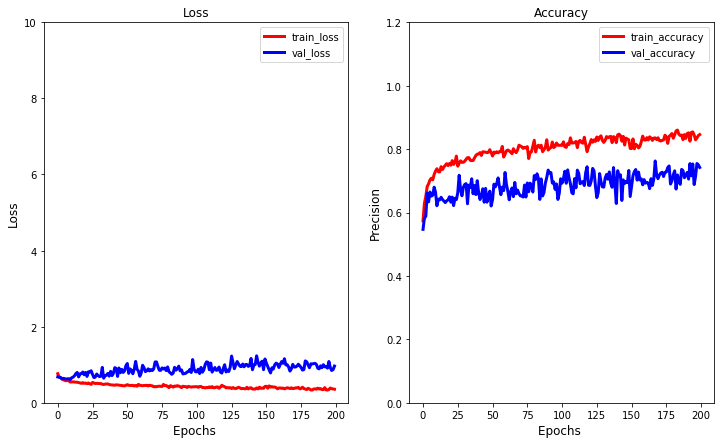

In [98]:
plt.rcParams['figure.figsize'] = [12, 7]

fig, axs = plt.subplots(nrows=1, ncols=2)
axs[0].plot(history.history['loss'], 'r', linewidth=3.0) 
axs[0].plot(history.history['val_loss'], 'b', linewidth=3.0)
axs[0].legend(['train_loss', 'val_loss'], fontsize=10)
axs[0].set_xlabel('Epochs ', fontsize=12)
axs[0].set_ylabel('Loss', fontsize=12)
axs[0].set_ylim(0,10)
axs[0].set_title('Loss', fontsize=12)

axs[1].plot(history.history['accuracy'], 'r', linewidth=3.0) 
axs[1].plot(history.history['val_accuracy'], 'b', linewidth=3.0)
axs[1].legend(['train_accuracy', 'val_accuracy'], fontsize=10)
axs[1].set_xlabel('Epochs ', fontsize=12)
axs[1].set_ylabel('Precision', fontsize=12) 
axs[1].set_ylim(0,1.2)
axs[1].set_title('Accuracy', fontsize=12)
plt.show()

# Evaluate the model

In [42]:
from metrics import confusion_matrix_sequencialOutput, confusion_matrix_sequencial_output_mean_std

### Training samples

In [43]:
TP, FP, TN, FN, conf_matrix = confusion_matrix_sequencialOutput(model, 
                                                                X_train, y_train, 
                                                                (gap_before_start_time + gap_after_start_time))

In [44]:
conf_matrix

array([[10746.,  1602.],
       [  553.,  7469.]])

In [45]:
print("Accuracy trainng: %.2f" % ((TP+TN)/(TP+FP+FN+TN)*100) + "%")
print("Recall trainng: %.2f" % (TP/(TP+FN)*100) + "%")
print("Precicion trainng: %.2f" % (TP/(TP+FP)*100) + "%")

Accuracy trainng: 89.42%
Recall trainng: 95.11%
Precicion trainng: 87.03%


### Testing samples

In [46]:
TP, FP, TN, FN, conf_matrix = confusion_matrix_sequencialOutput(model, 
                                                                X_test, y_test, 
                                                                (gap_before_start_time + gap_after_start_time))

In [47]:
conf_matrix

array([[3232., 1239.],
       [1554., 2765.]])

In [48]:
print("Accuracy testing: %.2f" % ((TP+TN)/(TP+FP+FN+TN)*100) + "%")
print("Recall testing: %.2f" % (TP/(TP+FN)*100) + "%")
print("Precicion testing: %.2f" % (TP/(TP+FP)*100) + "%")

Accuracy testing: 68.23%
Recall testing: 67.53%
Precicion testing: 72.29%


# Analysing similaritis

In [49]:
from metrics import similarity_sequential_output_percentage_correct

In [50]:
equal, similar, incorrect = similarity_sequential_output_percentage_correct(model, X_test, y_test, 80)

/home/sergi/Documents/PhD_UPC/RNN_v8_muac_weather/metrics.py:248: RuntimeWarning: invalid value encountered in true_divide
  percentage_correct_predictions = sum_prediction / sum_test_sample
/home/sergi/Documents/PhD_UPC/RNN_v8_muac_weather/metrics.py:248: RuntimeWarning: divide by zero encountered in true_divide
  percentage_correct_predictions = sum_prediction / sum_test_sample


In [51]:
equal, similar, incorrect

(0.5119453924914675, 0.2696245733788396, 0.21843003412969283)

# From many-to-many to many-to-one

In [52]:
from metrics import detect_regulations_binary, updated_detect_regulations_binary, updated_detect_regulations_binary_mean_std

In [53]:
TP_binary, FP_binary, TN_binary, FN_binary, conf_matrix_binary = detect_regulations_binary(model, X_test, y_test)

In [54]:
conf_matrix_binary

array([[173.,  36.],
       [  0.,  80.]])

In [55]:
print("Accuracy testing: %.2f" % ((TP_binary+TN_binary)/(TP_binary+FP_binary+FN_binary+TN_binary)*100) + "%")
print("Recall testing: %.2f" % (TP_binary/(TP_binary+FN_binary)*100) + "%")
print("Precicion testing: %.2f" % (TP_binary/(TP_binary+FP_binary)*100) + "%")

Accuracy testing: 87.54%
Recall testing: 100.00%
Precicion testing: 82.78%


In [56]:
TP_binary, FP_binary, TN_binary, FN_binary, conf_matrix_binary = updated_detect_regulations_binary(model, 
                                                                                                   X_test, 
                                                                                                   y_test, 10)

In [57]:
conf_matrix_binary

array([[115.,  38.],
       [ 56.,  84.]])

In [58]:
print("Accuracy testing: %.2f" % ((TP_binary+TN_binary)/(TP_binary+FP_binary+FN_binary+TN_binary)*100) + "%")
print("Recall testing: %.2f" % (TP_binary/(TP_binary+FN_binary)*100) + "%")
print("Precicion testing: %.2f" % (TP_binary/(TP_binary+FP_binary)*100) + "%")

Accuracy testing: 67.92%
Recall testing: 67.25%
Precicion testing: 75.16%


# Saving the model 

In [59]:
# model.save('./Counting_variables/Generic_20200614.h5')